In [1]:
# package(s) related to time, space and id
import datetime, time
import platform

# you need these dependencies (you can get these from anaconda)
# package(s) related to the simulation
import simpy

# package(s) for data handling
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None

import matplotlib.pyplot as plt
import seaborn as sns
# Use seaborn style defaults and set the default figure size
sns.set(rc={'figure.figsize':(11, 4)})
import matplotlib.dates as mdates



the current state is summarized by the number of turbines already built, the current time instance, the current location of each vessel (in port or offshore) and its current loading state, i.e. components for how many turbines are currently loaded on each vessel.

In [2]:
forecast_df = pd.read_csv("../demo/metocean_format_pieter_maart_2020_1_jaar.csv")
forecast_df = forecast_df.set_index(pd.to_datetime(forecast_df["Time"], dayfirst=True))

forecast_df = forecast_df.sort_index()

forecast_df["DateTime"] = [datetime.datetime.strptime(dt, '%d-%m-%Y %H:%M') for dt in forecast_df["Time"]]

In [3]:
forecast_df.head(3)

,Year,Month,Day,Hour,Hour.1,Time,U10 [m/s],Hs [m],DateTime
Time,,,,,,,,,
2020-03-01 00:00:00,2020,3,1,0,1,1-3-2020 00:00,7.4,1.832474,2020-03-01 00:00:00
2020-03-01 01:00:00,2020,3,1,1,2,1-3-2020 01:00,12.4,1.594841,2020-03-01 01:00:00
2020-03-01 02:00:00,2020,3,1,2,3,1-3-2020 02:00,18.4,1.612009,2020-03-01 02:00:00


In [4]:
uncertainty_df = pd.read_csv("../demo/uncertainty.csv")

uncertainty_df.head(3)

,HourIntoFuture,Uncertainty
0,0,0.000000
1,1,0.000218
2,2,0.000457


In [5]:
forecast_df = forecast_df.head(len(uncertainty_df))
average_Hs = forecast_df["Hs [m]"].sum()/len(forecast_df["Hs [m]"])
upper_bound = []
lower_bound = []

for hour in range(336):
    upper_bound.append(forecast_df["Hs [m]"][hour]+uncertainty_df["Uncertainty"][hour]*average_Hs)
    #upper_bound.append((1+uncertainty_df["Uncertainty"][hour])*forecast_df["Hs [m]"][hour])
    #lower_bound.append((1-uncertainty_df["Uncertainty"][hour])*forecast_df["Hs [m]"][hour])
    lower_bound.append(forecast_df["Hs [m]"][hour]-uncertainty_df["Uncertainty"][hour]*average_Hs)

        
upper_bound_df = pd.DataFrame(upper_bound)
lower_bound = [0 if i < 0 else i for i in lower_bound]
lower_bound_df = pd.DataFrame(lower_bound)

In [6]:
col_one_list = uncertainty_df['Uncertainty'].tolist()
forecast_df['Uncertainty'] = col_one_list
forecast_df['Hs upper'] = upper_bound
forecast_df['Hs lower'] = lower_bound

In [7]:
forecast_df.head(3)

,Year,Month,Day,Hour,Hour.1,Time,U10 [m/s],Hs [m],DateTime,Uncertainty,Hs upper,Hs lower
Time,,,,,,,,,,,,
2020-03-01 00:00:00,2020,3,1,0,1,1-3-2020 00:00,7.4,1.832474,2020-03-01 00:00:00,0.000000,1.832474,1.832474
2020-03-01 01:00:00,2020,3,1,1,2,1-3-2020 01:00,12.4,1.594841,2020-03-01 01:00:00,0.000218,1.595076,1.594607
2020-03-01 02:00:00,2020,3,1,2,3,1-3-2020 02:00,18.4,1.612009,2020-03-01 02:00:00,0.000457,1.612500,1.611518


In [8]:
forecast_df.tail(3)

,Year,Month,Day,Hour,Hour.1,Time,U10 [m/s],Hs [m],DateTime,Uncertainty,Hs upper,Hs lower
Time,,,,,,,,,,,,
2020-03-14 21:00:00,2020,3,14,21,22,14-3-2020 21:00,8.2,1.128918,2020-03-14 21:00:00,0.643975,1.821090,0.436745
2020-03-14 22:00:00,2020,3,14,22,23,14-3-2020 22:00,7.6,1.217405,2020-03-14 22:00:00,0.645993,1.911747,0.523064
2020-03-14 23:00:00,2020,3,14,23,24,14-3-2020 23:00,5.2,1.248971,2020-03-14 23:00:00,0.648001,1.945471,0.552471


In [42]:
t0 = forecast_df.index[0]
t1 = forecast_df.index[-1]

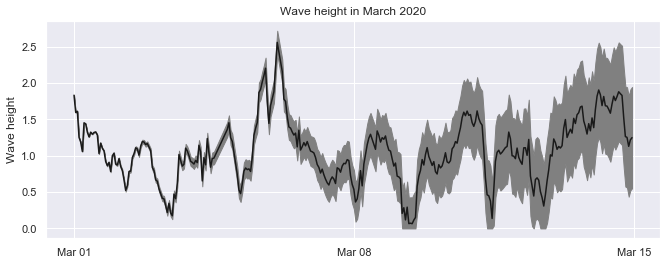

In [46]:
fig, ax = plt.subplots()
ax.plot(forecast_df.loc[t0:t1, 'Hs [m]'], linestyle='-',color='k')
ax.fill_between(forecast_df.loc[t0:t1, 'DateTime'],forecast_df.loc[t0:t1, 'Hs lower'],forecast_df.loc[t0:t1, 'Hs upper'],color='grey')
ax.set_ylabel('Wave height')
ax.set_title('Wave height in March 2020')
# Set x-axis major ticks to weekly interval, on Mondays
ax.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=mdates.SUNDAY))
# Format x-tick labels as 3-letter month name and day number
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'));